In [1]:
from vdna import VDNAProcessor, EMD, load_vdna_from_files
import json
import os
import torch

device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

vdna_proc = VDNAProcessor()

# Configuration dictionary
config = {
     # Adjust this path as needed
    "vdna_cityscapes": "datasets/data_2/cityscapes/leftImg8bit/train/",
    "vdna_city_inception_output": "datasets/data_2/cityscapes/vdna_mugs_vit_base", 
}

vdna_city = vdna_proc.make_vdna(source=config["vdna_cityscapes"], device=device, num_workers=0, feat_extractor_name="mugs_vit_base", crop_to_square_pre_resize="center")
vdna_city.save(config["vdna_city_inception_output"])

c:\Users\sumal\anaconda3\envs\temp_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 2975 images in the provided source
Using 2975 images


100%|██████████| 47/47 [08:31<00:00, 10.88s/it]


In [1]:
from vdna import VDNAProcessor, EMD, load_vdna_from_files
import json
import os
import torch

device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

vdna_proc = VDNAProcessor()

# Configuration dictionary
config = {
     # Adjust this path as needed
    "vdna_kitti": "datasets/data/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect/",
    "vdna_kitti_inception_output": "datasets/data/KITTI-360/vdna_mugs_vit_base", 
}

vdna_kitti_360 = vdna_proc.make_vdna(source=config["vdna_kitti"], device=device, num_workers=0, feat_extractor_name="mugs_vit_base", crop_to_square_pre_resize="center")
vdna_kitti_360.save(config["vdna_kitti_inception_output"])

c:\Users\sumal\anaconda3\envs\temp_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 11518 images in the provided source
Using 11518 images


100%|██████████| 180/180 [13:21<00:00,  4.45s/it]


In [2]:
# ----- Comparing VDNAs -----
# Earth Mover's Distance used to compare histogram-based VDNAs
from vdna import load_vdna_from_files, EMD

vdna1 = load_vdna_from_files("datasets/data_2/cityscapes/vdna_mugs_vit_base")
vdna2 = load_vdna_from_files("datasets/data/KITTI-360/vdna_mugs_vit_base")

print("EMD averaged over all neuron comparisons:")
print(EMD(vdna1, vdna2))

#print("EMD averaged over all neurons of block_0:")
#print(EMD(vdna1, vdna2, use_neurons_from_layer="block_0"))

print("EMD of every layer")
layers = vdna1.neurons_list.keys()
for layer in layers:
    # print(f"layer: {layer}")
    print(f"EMD of layer {layer}: {EMD(vdna1, vdna2, use_neurons_from_layer=layer)}")

EMD averaged over all neuron comparisons:
tensor(11.8797, dtype=torch.float64)
EMD of every layer
EMD of layer block_0: 7.528912552626447
EMD of layer block_1: 8.257890050649438
EMD of layer block_2: 8.923860435298467
EMD of layer block_3: 10.869407752088833
EMD of layer block_4: 11.892573448751952
EMD of layer block_5: 12.093044372965357
EMD of layer block_6: 12.945226892740871
EMD of layer block_7: 12.321226649928755
EMD of layer block_8: 11.450902235251405
EMD of layer block_9: 11.613603558113759
EMD of layer block_10: 12.738690045315536
EMD of layer block_11: 15.085205031229265
EMD of layer last_norm: 18.71496893551693


In [ ]:
from vdna import VDNAProcessor, EMD, load_vdna_from_files
import json
import os
import torch

device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"


vdna_proc = VDNAProcessor()

# Configuration dictionary
config = {
    "input_json_path": "datasets/image_entropy_batch_12.json",
    "output_json_path": "datasets/image_entropy_batch_12_emd.json",
    "vdna_cityscapes_path": "outputs/weaklabels/KITTI-360/vdna_cityscapes",  # Adjust this path as needed
    "vdna_kitti_path": "outputs/weaklabels/KITTI-360/kitti_360_single_image"
}


# Load the input JSON file
with open(config["input_json_path"], 'r') as json_file:
    data = json.load(json_file)

# Load the pre-computed Cityscapes VDNA
vdna_cityscapes = load_vdna_from_files(config["vdna_cityscapes_path"])

# Process images and compute EMD
for item in data:
    image_path = item["image_path"]
    
    if os.path.exists(image_path):
        # Compute VDNA for the current image
        vdna_kitti = vdna_proc.make_vdna(source=image_path, device=device, num_workers=0, feat_extractor_name="dinov2_small_224", crop_to_square_pre_resize="center")
        vdna_kitti.save(config["vdna_kitti_path"])

        vdna_kitti_load = load_vdna_from_files(config["vdna_kitti_path"])
        
        # Calculate EMD
        emd = EMD(vdna_cityscapes, vdna_kitti_load, use_neurons_from_layer="block_11")
        
        # Convert tensor to float
        if isinstance(emd, torch.Tensor):
            emd = emd.item()
        
        # Add EMD to the item
        item["emd_block_11"] = float(emd)
    else:
        print(f"Warning: Image file not found: {image_path}")
        item["emd_block_11"] = None

# Sort the results by EMD
data = sorted(data, key=lambda x: x['emd_block_11'] if x['emd_block_11'] is not None else float('inf'))

# Save the results to a JSON file
#os.makedirs(os.path.dirname(config["output_json_path"]), exist_ok=True)

with open(config["output_json_path"], 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Processing complete. Updated JSON saved as '{config['output_json_path']}'.")

In [3]:
with open(config["output_json_path"], 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Processing complete. Updated JSON saved as '{config['output_json_path']}'.")

Processing complete. Updated JSON saved as 'results_v2.json'.


In [20]:
import json
import glob
import os

# Path to your JSON files
path = 'datasets/'

# List to store all the data
all_data = []

# Get all JSON files matching the pattern
json_pattern = os.path.join(path, 'image_entropy_batch_*_emd.json')
file_list = glob.glob(json_pattern)

# Read each file and append its contents to all_data
for file_path in file_list:
    with open(file_path, 'r') as file:
        data = json.load(file)
        if isinstance(data, list):
            all_data.extend(data)
        else:
            all_data.append(data)

# Write the combined data to master.json
with open('master.json', 'w') as outfile:
    json.dump(all_data, outfile, indent=4)

print(f"Combined {len(file_list)} files into master.json")

# Optional: Display the first few items in the combined data
print("\nFirst few items in the combined data:")
for item in all_data[:5]:  # Display first 5 items
    print(item)

Combined 12 files into master.json

First few items in the combined data:
{'image_path': 'datasets/data/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect\\0000009693.png', 'entropy': 0.12251994013786316, 'confidence': 0.9597049951553345, 'class_count': 11, 'emd_block_11': 18.3367549237594}
{'image_path': 'datasets/data/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect\\0000009696.png', 'entropy': 0.11257083714008331, 'confidence': 0.963198184967041, 'class_count': 12, 'emd_block_11': 18.49272459032252}
{'image_path': 'datasets/data/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect\\0000009691.png', 'entropy': 0.15571455657482147, 'confidence': 0.949367880821228, 'class_count': 11, 'emd_block_11': 18.503126675767593}
{'image_path': 'datasets/data/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect\\0000009683.png', 'entropy': 0.2118905484676361, 'confidence': 0.928540825843811, 'class_count': 10, 'emd_block_11': 18.58

First few rows of the data:


,entropy,confidence,class_count,emd_block_11
0,0.122520,0.959705,11,18.336755
1,0.112571,0.963198,12,18.492725
2,0.155715,0.949368,11,18.503127
3,0.211891,0.928541,10,18.589145
4,0.161595,0.944066,10,18.596837


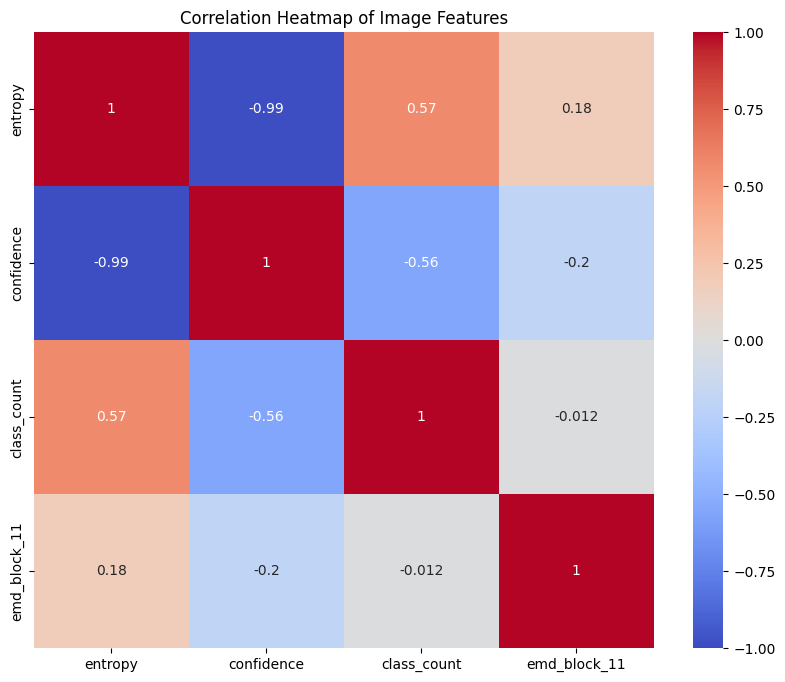


Correlation Matrix:


,entropy,confidence,class_count,emd_block_11
entropy,1.000000,-0.992018,0.573752,0.175718
confidence,-0.992018,1.000000,-0.556900,-0.198000
class_count,0.573752,-0.556900,1.000000,-0.011952
emd_block_11,0.175718,-0.198000,-0.011952,1.000000


In [21]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data from master.json
with open('master.json', 'r') as file:
    data = json.load(file)

# Extract the relevant features into a DataFrame
df = pd.DataFrame([{
    'entropy': item['entropy'],
    'confidence': item['confidence'],
    'class_count': item['class_count'],
    'emd_block_11': item['emd_block_11']
} for item in data])

# Display the first few rows of the DataFrame
print("First few rows of the data:")
display(df.head())

# Compute the correlation matrix
corr_matrix = df.corr()

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Set the title
plt.title('Correlation Heatmap of Image Features')

# Show the plot
plt.show()

# Display the correlation matrix
print("\nCorrelation Matrix:")
display(corr_matrix)

First few rows of the data:


,entropy,confidence,class_count,emd
0,0.217161,0.928414,11,9.013519
1,0.205337,0.929621,10,8.939378
2,0.200034,0.931099,14,9.141256
3,0.201385,0.931022,12,9.987525
4,0.271721,0.912737,14,9.679657


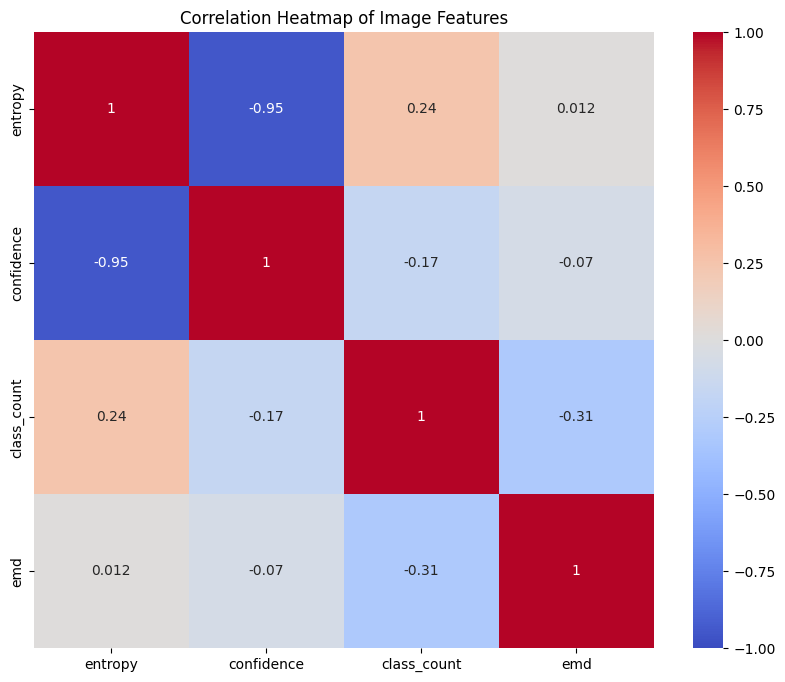


Correlation Matrix:


,entropy,confidence,class_count,emd
entropy,1.000000,-0.950875,0.244858,0.012444
confidence,-0.950875,1.000000,-0.169422,-0.070154
class_count,0.244858,-0.169422,1.000000,-0.311618
emd,0.012444,-0.070154,-0.311618,1.000000


In [22]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data from master.json
with open('results_v3.json', 'r') as file:
    data = json.load(file)

# Extract the relevant features into a DataFrame
df = pd.DataFrame([{
    'entropy': item['entropy'],
    'confidence': item['confidence'],
    'class_count': item['class_count'],
    'emd': item['emd']
} for item in data])

# Display the first few rows of the DataFrame
print("First few rows of the data:")
display(df.head())

# Compute the correlation matrix
corr_matrix = df.corr()

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Set the title
plt.title('Correlation Heatmap of Image Features')

# Show the plot
plt.show()

# Display the correlation matrix
print("\nCorrelation Matrix:")
display(corr_matrix)

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
# Load the JSON file
with open('master.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

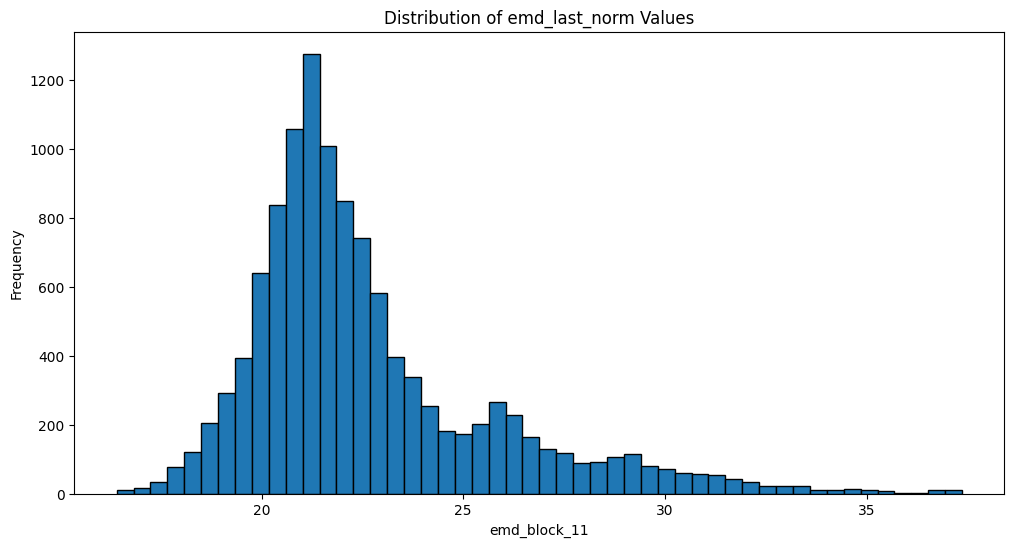

In [25]:
plt.figure(figsize=(12, 6))
plt.hist(df['emd_block_11'], bins=50, edgecolor='black')
plt.title('Distribution of emd_last_norm Values')
plt.xlabel('emd_block_11')
plt.ylabel('Frequency')
plt.show()

In [52]:
import json
import numpy as np
import pandas as pd
import random
import os

# Load the data from master.json
with open('master.json', 'r') as file:
    data = json.load(file)

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# df = df[df['class_count'] >= 9]

# df = df[df['entropy'] <= 0.10]

# Find the min and max values of emd_block_11
min_val = df['emd_block_11'].min()
max_val = df['emd_block_11'].max()

print(f"Min value of emd_block_11: {min_val}")
print(f"Max value of emd_block_11: {max_val}")

# Create 10 equal intervals between min and max
intervals = np.linspace(min_val, max_val, 6)

# Create a directory to store the rank files if it doesn't exist
output_dir = 'rank_files'
os.makedirs(output_dir, exist_ok=True)

# Split the data into 5 intervals and pick 5 random samples from each interval
for i in range(5):
    interval_data = df[(df['emd_block_11'] >= intervals[i]) & (df['emd_block_11'] < intervals[i+1])]
    print(f"Interval {i+1}: {len(interval_data)} records")
    
    if len(interval_data) >= 10:
        # sampled_data = interval_data.sample(10, random_state=42).to_dict(orient='records')
        sampled_data = interval_data.sample(min(3000, len(interval_data)), random_state=42).to_dict(orient='records')
    else:
        sampled_data = interval_data.to_dict(orient='records')
    
    # Save the sampled data to a JSON file
    output_file = os.path.join(output_dir, f'rank_{i+1}.json')
    with open(output_file, 'w') as outfile:
        json.dump(sampled_data, outfile, indent=4)

    print(f"Saved {len(sampled_data)} records to {output_file}")

print("All rank files have been created.")

Min value of emd_block_11: 16.40770284621632
Max value of emd_block_11: 37.37017080908241
Interval 1: 2616 records
Saved 2616 records to rank_files\rank_1.json
Interval 2: 6683 records
Saved 3000 records to rank_files\rank_2.json
Interval 3: 1566 records
Saved 1566 records to rank_files\rank_3.json
Interval 4: 559 records
Saved 559 records to rank_files\rank_4.json
Interval 5: 93 records
Saved 93 records to rank_files\rank_5.json
All rank files have been created.


In [53]:
import json
import os
import glob

def normalize_path(path):
    return path.replace('\\', '/')

def update_rank_files(rank_dir):
    # Get all rank JSON files
    rank_files = glob.glob(os.path.join(rank_dir, 'rank_*.json'))

    for rank_file in rank_files:
        with open(rank_file, 'r') as file:
            data = json.load(file)

        updated_data = []
        for item in data:
            image_path = normalize_path(item['image_path'])
            
            # Construct ground truth path
            ground_truth_path = normalize_path(image_path.replace(
                'data_2d_raw', 'data_2d_semantics/train'
            ).replace('data_rect', 'semantic'))

            # Check if files exist
            image_exists = os.path.isfile(image_path)
            ground_truth_exists = os.path.isfile(ground_truth_path)

            # Create updated entry
            updated_entry = {
                "image": image_path,
                "ground_truth": ground_truth_path,
                "image_exists": image_exists,
                "ground_truth_exists": ground_truth_exists,
                "entropy": item.get('entropy', None),
                "confidence": item.get('confidence', None),
                "class_count": item.get('class_count', None),
                "emd_block_11": item.get('emd_block_11', None)
            }

            updated_data.append(updated_entry)

        # Write updated data back to the file
        with open(rank_file, 'w') as file:
            json.dump(updated_data, file, indent=4)

        print(f"Updated {rank_file}")

# Directory containing rank JSON files
rank_dir = 'rank_files'

# Run the update function
update_rank_files(rank_dir)

Updated rank_files\rank_1.json
Updated rank_files\rank_2.json
Updated rank_files\rank_3.json
Updated rank_files\rank_4.json
Updated rank_files\rank_5.json


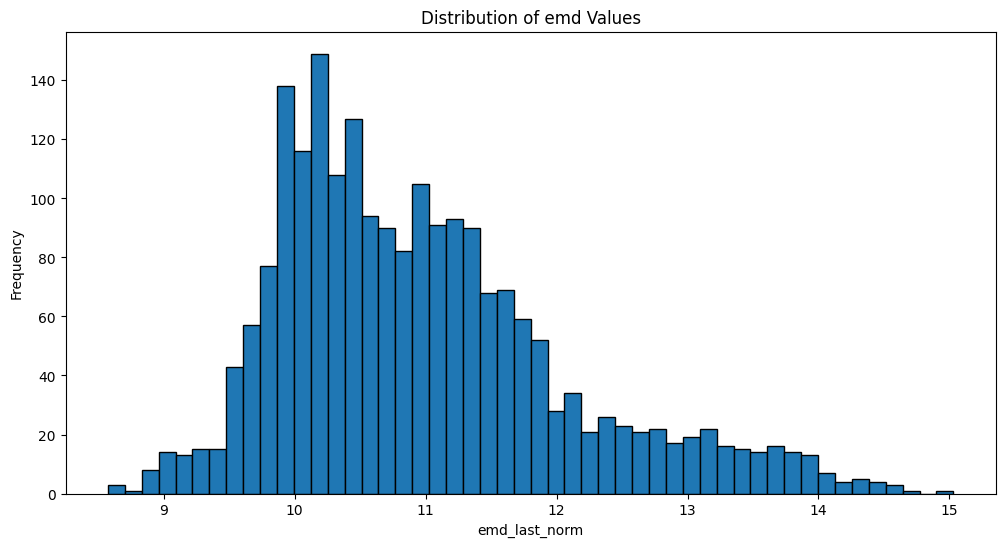

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(df['emd'], bins=50, edgecolor='black')
plt.title('Distribution of emd Values')
plt.xlabel('emd_last_norm')
plt.ylabel('Frequency')
plt.show()

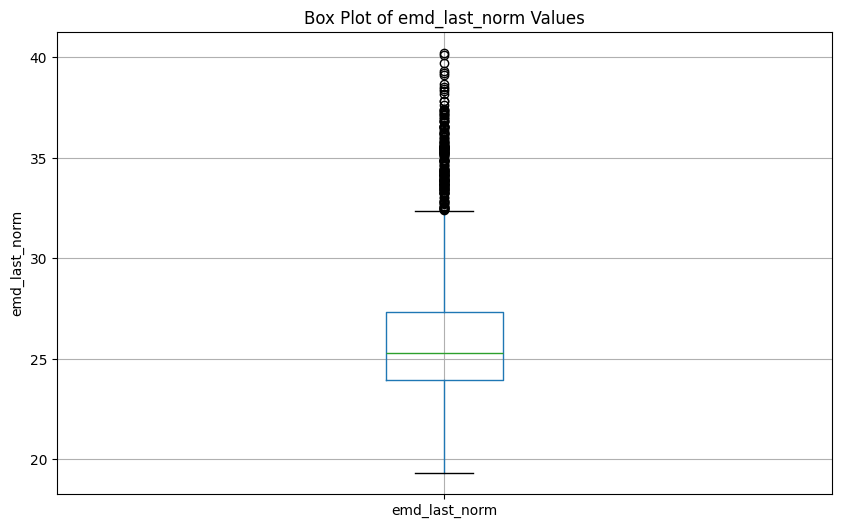

In [9]:
plt.figure(figsize=(10, 6))
df.boxplot(column=['emd_last_norm'])
plt.title('Box Plot of emd_last_norm Values')
plt.ylabel('emd_last_norm')
plt.show()

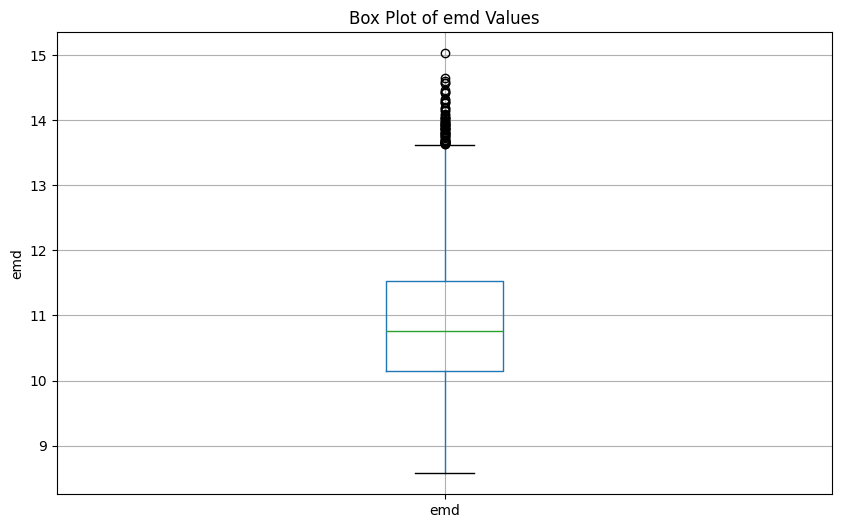

In [10]:
plt.figure(figsize=(10, 6))
df.boxplot(column=['emd'])
plt.title('Box Plot of emd Values')
plt.ylabel('emd')
plt.show()

C:\Users\sumal\AppData\Local\Temp\ipykernel_25448\279769867.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df['emd_last_norm'], shade=True)


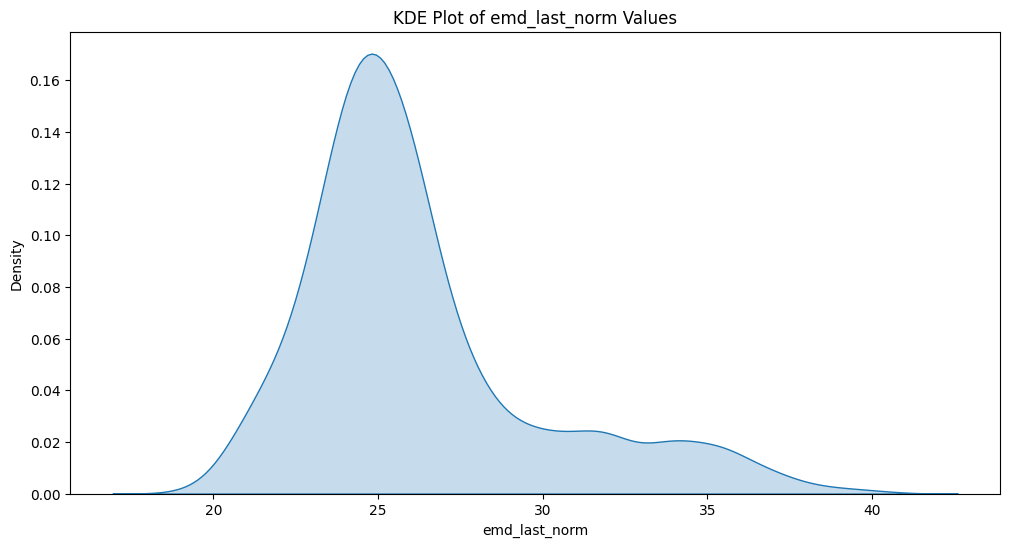

In [11]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df['emd_last_norm'], shade=True)
plt.title('KDE Plot of emd_last_norm Values')
plt.xlabel('emd_last_norm')
plt.ylabel('Density')
plt.show()

C:\Users\sumal\AppData\Local\Temp\ipykernel_25448\1941070248.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df['emd'], shade=True)


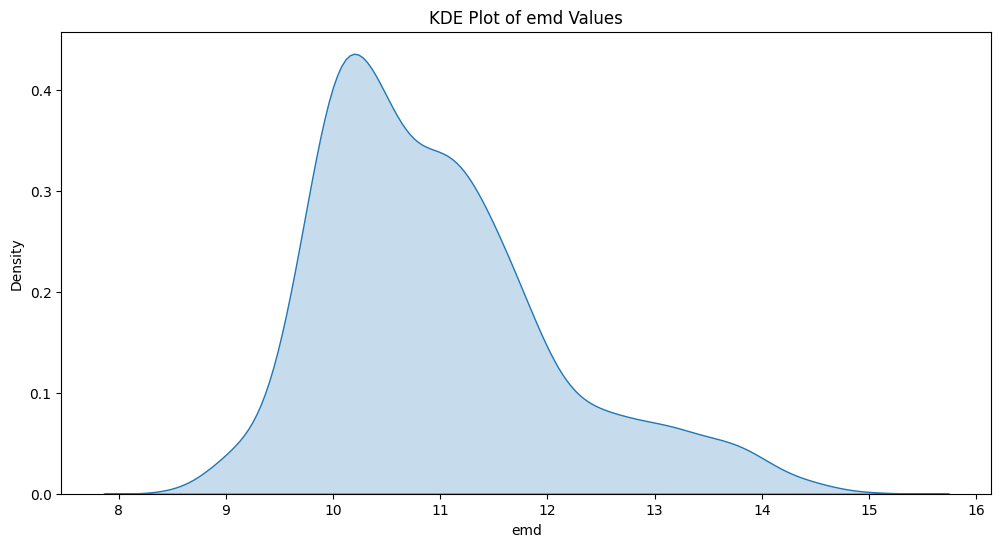

In [12]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df['emd'], shade=True)
plt.title('KDE Plot of emd Values')
plt.xlabel('emd')
plt.ylabel('Density')
plt.show()

In [13]:
stats = df['emd_last_norm'].describe()
print(stats)

count    2123.000000
mean       26.238180
std         3.684351
min        19.319216
25%        23.967683
50%        25.310960
75%        27.336047
max        40.214630
Name: emd_last_norm, dtype: float64


In [14]:
stats = df['emd'].describe()
print(stats)

count    2123.000000
mean       10.965454
std         1.104684
min         8.574124
25%        10.150134
50%        10.763608
75%        11.536472
max        15.030257
Name: emd, dtype: float64


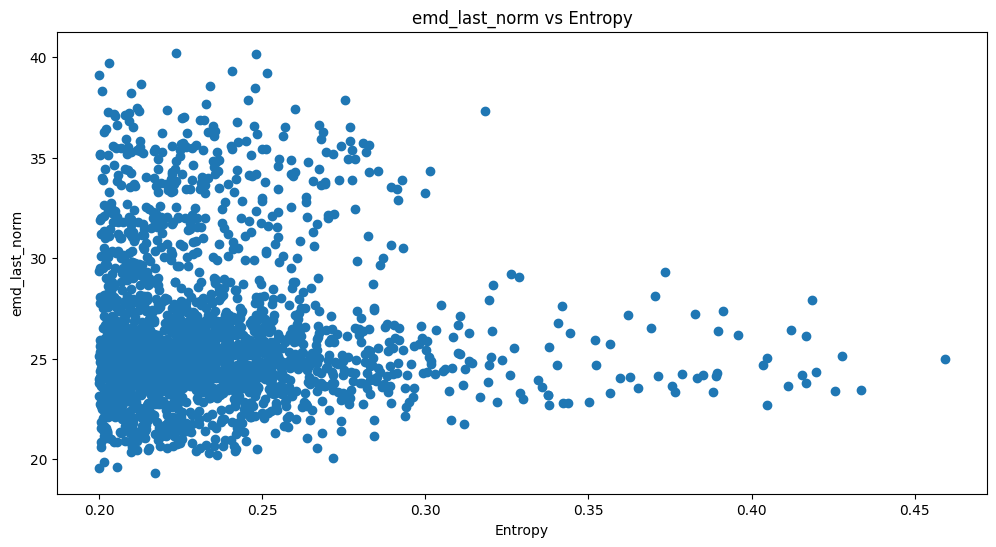

<Figure size 1400x600 with 0 Axes>

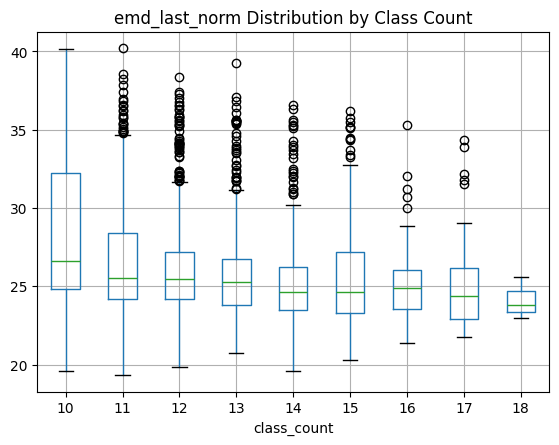

In [15]:
# Scatter plot of emd_last_norm vs entropy
plt.figure(figsize=(12, 6))
plt.scatter(df['entropy'], df['emd_last_norm'])
plt.title('emd_last_norm vs Entropy')
plt.xlabel('Entropy')
plt.ylabel('emd_last_norm')
plt.show()

# Box plot of emd_last_norm grouped by class_count
plt.figure(figsize=(14, 6))
df.boxplot(column='emd_last_norm', by='class_count')
plt.title('emd_last_norm Distribution by Class Count')
plt.suptitle('')  # This removes the automatic suptitle
plt.show()

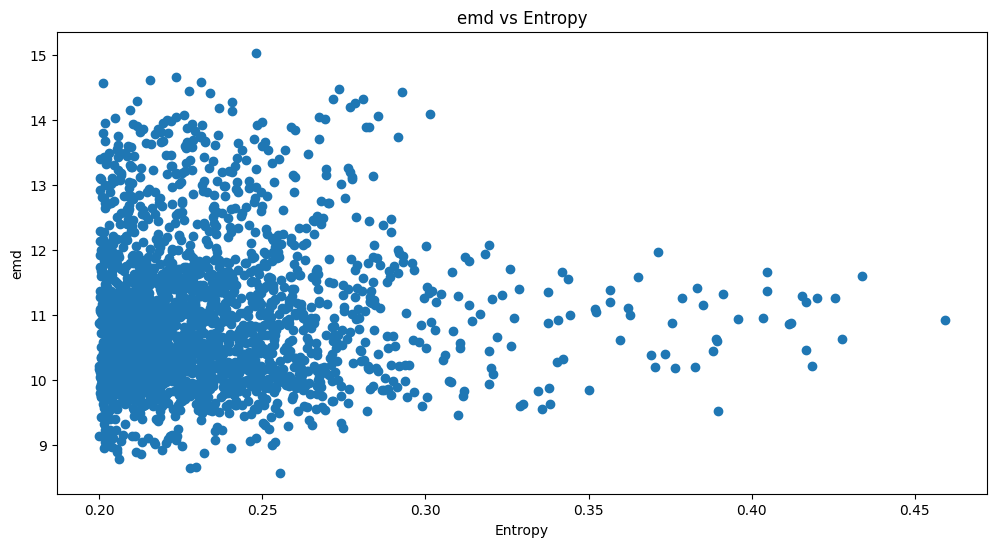

<Figure size 1400x600 with 0 Axes>

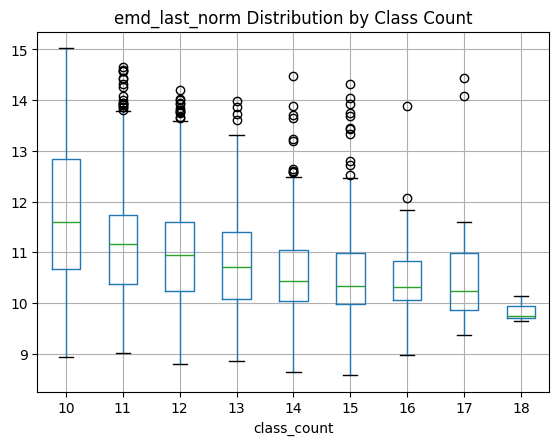

In [16]:
# Scatter plot of emd_last_norm vs entropy
plt.figure(figsize=(12, 6))
plt.scatter(df['entropy'], df['emd'])
plt.title('emd vs Entropy')
plt.xlabel('Entropy')
plt.ylabel('emd')
plt.show()

# Box plot of emd_last_norm grouped by class_count
plt.figure(figsize=(14, 6))
df.boxplot(column='emd', by='class_count')
plt.title('emd_last_norm Distribution by Class Count')
plt.suptitle('')  # This removes the automatic suptitle
plt.show()

               emd  emd_last_norm
count  2123.000000    2123.000000
mean     10.965454      26.238180
std       1.104684       3.684351
min       8.574124      19.319216
25%      10.150134      23.967683
50%      10.763608      25.310960
75%      11.536472      27.336047
max      15.030257      40.214630


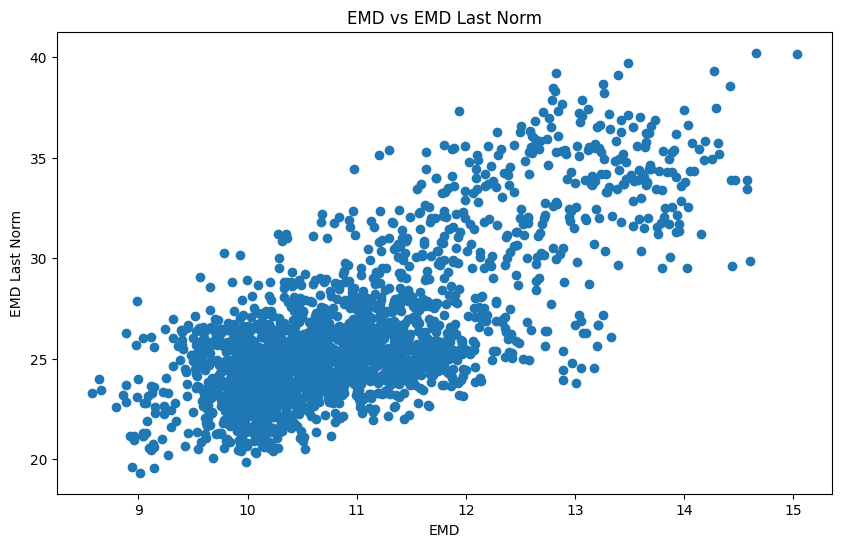

Correlation between EMD and EMD Last Norm: 0.7317993645705635


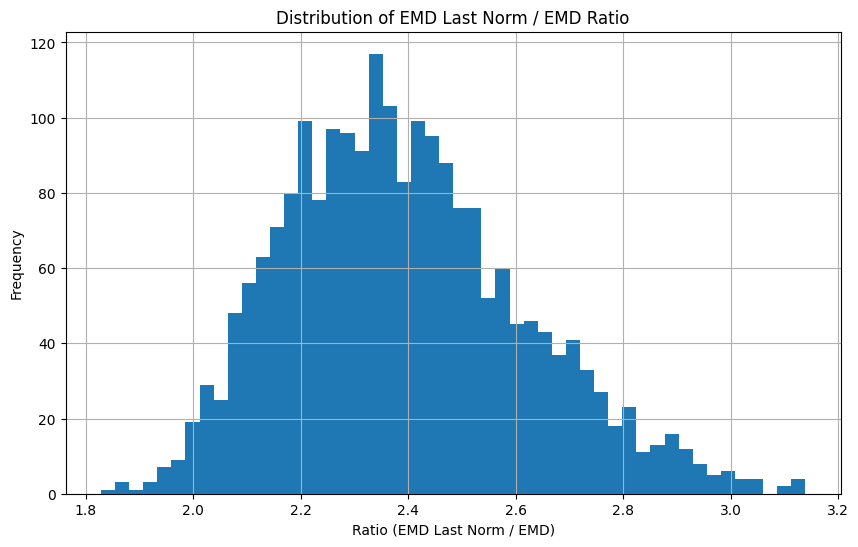

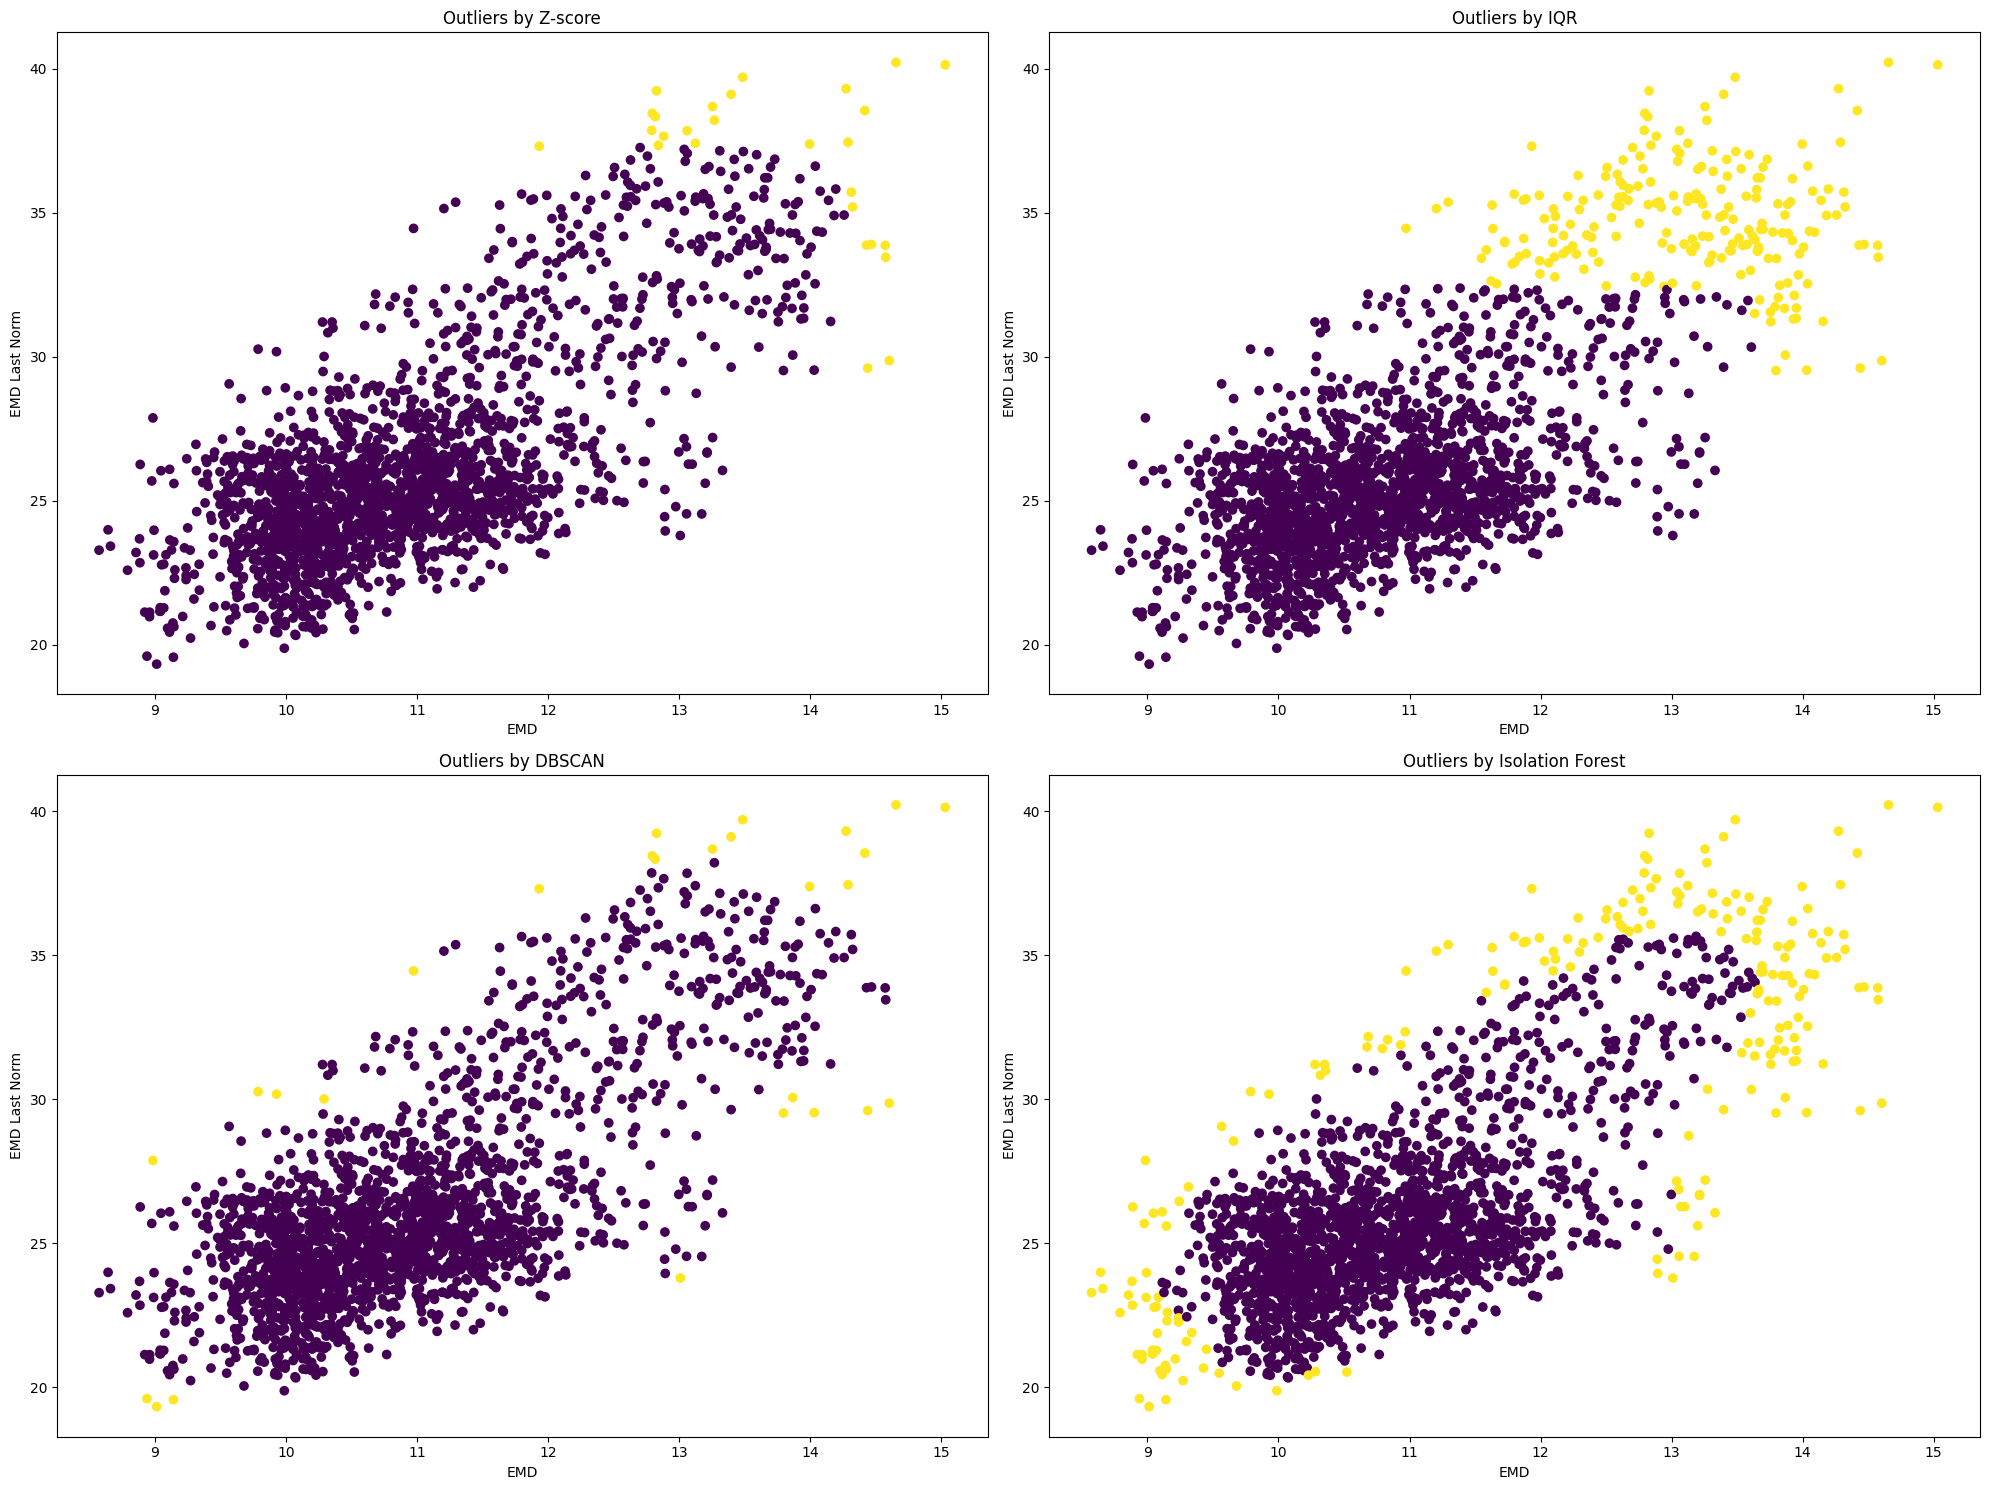

Outlier Statistics:
          entropy  confidence  class_count         emd  emd_last_norm  \
count  297.000000  297.000000   297.000000  297.000000     297.000000   
mean     0.230871    0.920229    12.077441   12.307257      31.880432   
std      0.024459    0.009663     1.742958    1.701574       5.188572   
min      0.200034    0.887703    10.000000    8.574124      19.319216   
25%      0.210426    0.914233    11.000000   11.664314      30.051250   
50%      0.225480    0.922696    12.000000   12.894081      33.701313   
75%      0.245968    0.927441    13.000000   13.570633      35.377051   
max      0.318203    0.935732    17.000000   15.030257      40.214630   

            ratio  
count  297.000000  
mean     2.595080  
std      0.289983  
min      1.828354  
25%      2.413040  
50%      2.619427  
75%      2.819338  
max      3.139393  


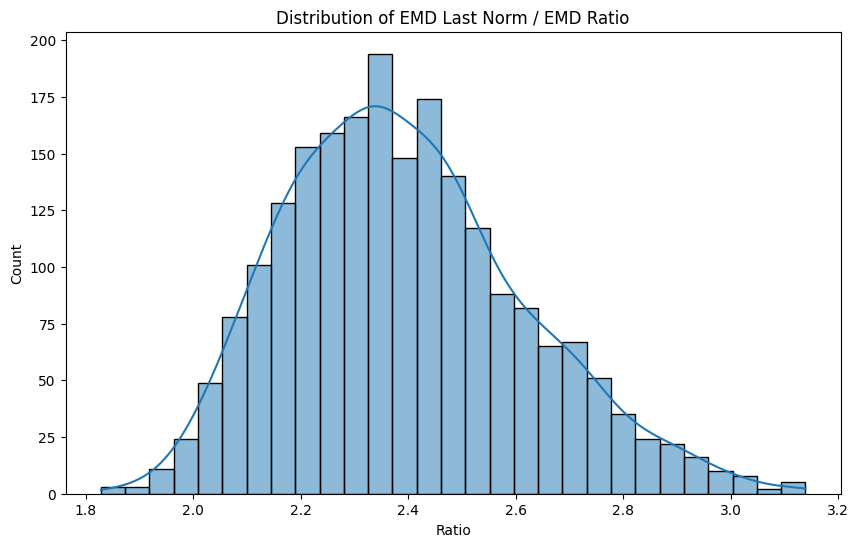

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import seaborn as sns

# Step 1: Data Collection and Preparation
def load_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    if isinstance(data, list):
        return pd.DataFrame(data)
    elif isinstance(data, dict):
        return pd.DataFrame.from_dict(data, orient='index')
    else:
        raise ValueError("Unexpected JSON structure")

# Replace 'path/to/your/json/files' with the actual path to your JSON files
df = load_json_file('results_v2.json')

# Step 2: Exploratory Data Analysis
print(df[['emd', 'emd_last_norm']].describe())

plt.figure(figsize=(10, 6))
plt.scatter(df['emd'], df['emd_last_norm'])
plt.xlabel('EMD')
plt.ylabel('EMD Last Norm')
plt.title('EMD vs EMD Last Norm')
plt.show()

# Step 3: Correlation Analysis
correlation = df['emd'].corr(df['emd_last_norm'])
print(f"Correlation between EMD and EMD Last Norm: {correlation}")

# Step 4: Ratio Analysis
df['ratio'] = df['emd_last_norm'] / df['emd']
plt.figure(figsize=(10, 6))
df['ratio'].hist(bins=50)
plt.xlabel('Ratio (EMD Last Norm / EMD)')
plt.ylabel('Frequency')
plt.title('Distribution of EMD Last Norm / EMD Ratio')
plt.show()

# Step 5: Outlier Detection

# a) Z-score method
z_scores = np.abs(stats.zscore(df[['emd', 'emd_last_norm']]))
outliers_z = np.any(z_scores > 3, axis=1)

# b) IQR method
Q1 = df[['emd', 'emd_last_norm']].quantile(0.25)
Q3 = df[['emd', 'emd_last_norm']].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = np.any((df[['emd', 'emd_last_norm']] < (Q1 - 1.5 * IQR)) | 
                      (df[['emd', 'emd_last_norm']] > (Q3 + 1.5 * IQR)), axis=1)

# c) DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
outliers_dbscan = dbscan.fit_predict(df[['emd', 'emd_last_norm']]) == -1

# d) Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers_iforest = iso_forest.fit_predict(df[['emd', 'emd_last_norm']]) == -1

# Step 6: Visualization of Outliers
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.scatter(df['emd'], df['emd_last_norm'], c=outliers_z, cmap='viridis')
plt.title('Outliers by Z-score')
plt.xlabel('EMD')
plt.ylabel('EMD Last Norm')

plt.subplot(2, 2, 2)
plt.scatter(df['emd'], df['emd_last_norm'], c=outliers_iqr, cmap='viridis')
plt.title('Outliers by IQR')
plt.xlabel('EMD')
plt.ylabel('EMD Last Norm')

plt.subplot(2, 2, 3)
plt.scatter(df['emd'], df['emd_last_norm'], c=outliers_dbscan, cmap='viridis')
plt.title('Outliers by DBSCAN')
plt.xlabel('EMD')
plt.ylabel('EMD Last Norm')

plt.subplot(2, 2, 4)
plt.scatter(df['emd'], df['emd_last_norm'], c=outliers_iforest, cmap='viridis')
plt.title('Outliers by Isolation Forest')
plt.xlabel('EMD')
plt.ylabel('EMD Last Norm')

plt.tight_layout()
plt.show()

# Step 7: Analysis of Outliers
outliers = df[outliers_z | outliers_iqr | outliers_dbscan | outliers_iforest]
print("Outlier Statistics:")
print(outliers.describe())

# Step 8: Normalization Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['ratio'], kde=True)
plt.title('Distribution of EMD Last Norm / EMD Ratio')
plt.xlabel('Ratio')
plt.show()

Correlation between EMD and EMD Last Norm: 0.7286275436978511


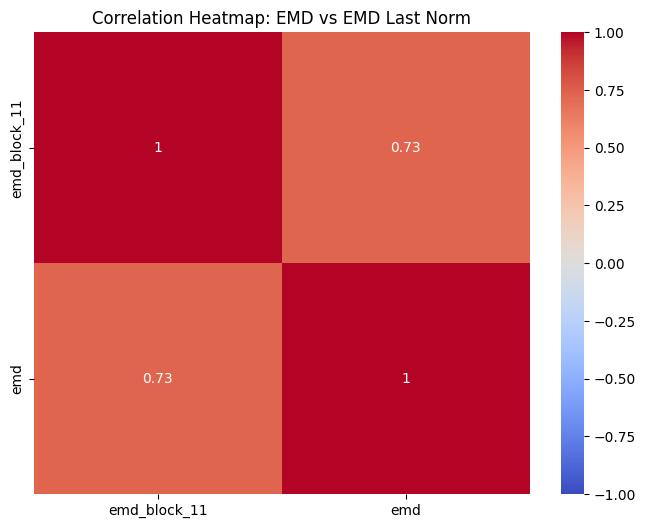

In [7]:
# Step 3: Correlation Analysis
correlation = df['emd_block_11'].corr(df['emd'])
print(f"Correlation between EMD and EMD Last Norm: {correlation}")

# Plotting Correlation Heatmap
corr_matrix = df[['emd_block_11', 'emd']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap: EMD vs EMD Last Norm')
plt.show()

Number of entries: 11518
Average Entropy: 0.1556308309192313
count    11518.000000
mean         0.155631
std          0.056547
min          0.038730
25%          0.118073
50%          0.155682
75%          0.190015
max          0.521496
Name: entropy, dtype: float64


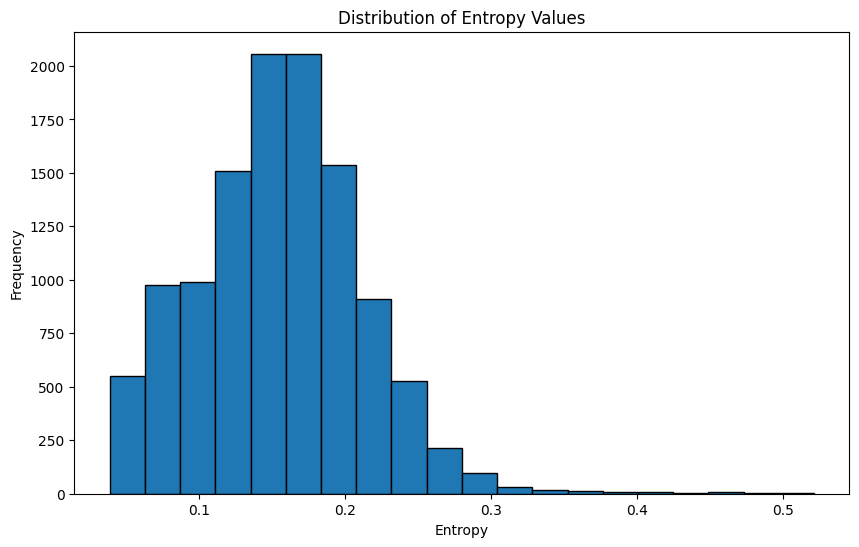

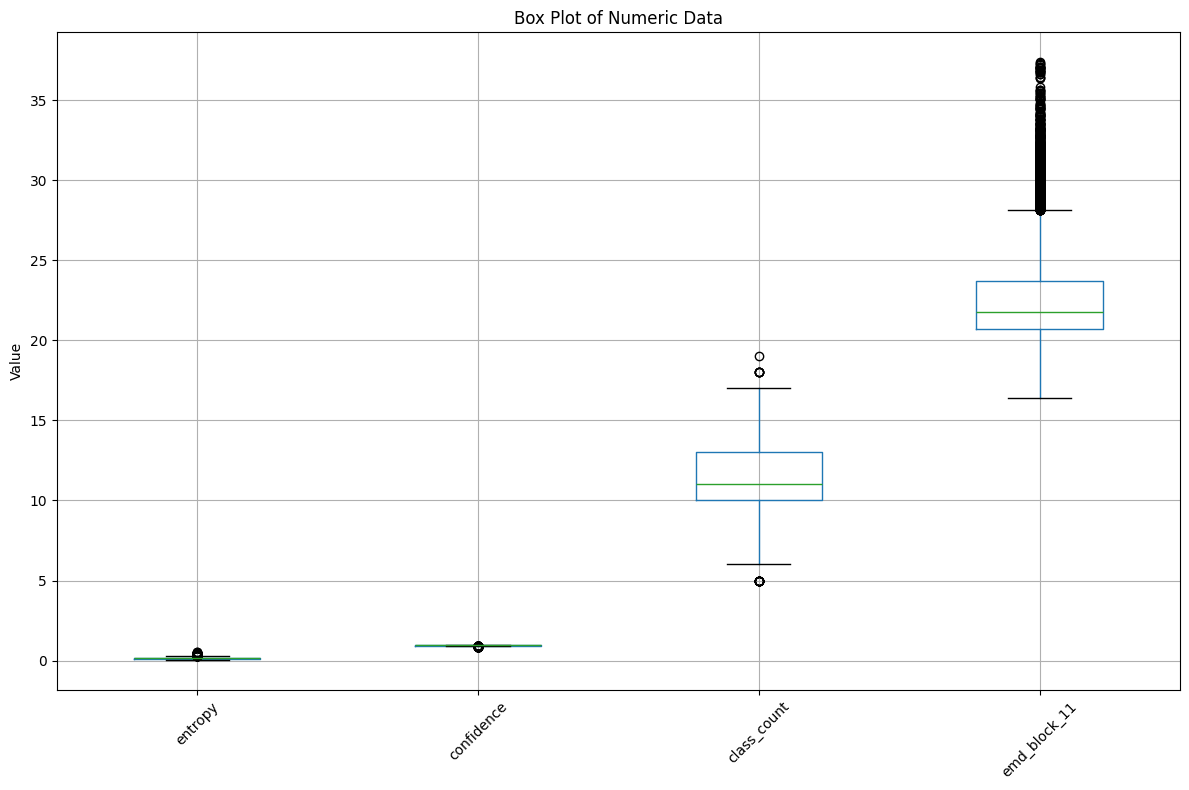

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Cell 1: Read the JSON file

# Specify the path to your JSON file
json_file_path = 'master.json'

# Read the JSON file
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Cell 2: Extract entropy values and calculate average

# Extract entropy values
entropy_values = [entry['entropy'] for entry in data]

# Calculate average entropy
average_entropy = sum(entropy_values) / len(entropy_values)

print(f"Number of entries: {len(entropy_values)}")
print(f"Average Entropy: {average_entropy}")

# Cell 3: Create a DataFrame for further analysis

df = pd.DataFrame(data)
print(df['entropy'].describe())

# Cell 4: Visualize the distribution of entropy values

plt.figure(figsize=(10, 6))
plt.hist(entropy_values, bins=20, edgecolor='black')
plt.title('Distribution of Entropy Values')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.show()

# Cell 5: Optional - Visualize other numeric data

numeric_columns = ['entropy', 'confidence', 'class_count', 'emd_block_11']

plt.figure(figsize=(12, 8))
df[numeric_columns].boxplot()
plt.title('Box Plot of Numeric Data')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()